<img src="https://ucfai.org/core/fa19/cnns/banner.png">

<div class="col-12">
    <span class="btn btn-success btn-block">
        Meeting in-person? Have you signed in?
    </span>
</div>

<div class="col-12">
    <h1> How We Can Give Our Computers Eyes and Ears </h1>
    <hr>
</div>

<div style="line-height: 2em;">
    <p>by: 
        <strong> Daniel Silva</strong>
        (<a href="https://github.com/danielzgsilva">@danielzgsilva</a>)
    
        <strong> Brandon</strong>
        (<a href="https://github.com/brandons209">@brandons209</a>)
     on 2019-10-16</p>
</div>

# Convolutional Neural Networks and Transfer Learning Workshop

## Set up 

Importing some of the libraries we'll be using, as well as PyTorch:

In [0]:
# standard imports (Numpy, Pandas, Matplotlib)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# PyTorch imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils
from torch.utils.data import DataLoader
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision import transforms
from torchsummary import summary

# Extras
import time
import os

The script below downloads the dataset for today's lesson.

In [0]:
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip > /dev/null

In [233]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline
random.seed(42)

Populating the interactive namespace from numpy and matplotlib


In [234]:
from google.colab import drive
drive.mount('/content/gdrive')
root = '/content/gdrive/My Drive/ucfai/core/fa19/05-cnns/'

Mounted at /content/gdrive


## Building a Convolutional Neural Network with PyTorch

Now that we understand the details behind CNNs, let's take a look at how we can build one of these networks using the **[PyTorch](https://pytorch.org/docs/stable/index.html)** framework. As I mentioned earlier, CNNs can be used to understand all sorts of data, but for this meeting we'll build a network to classify images. This is called **Computer Vision**.

Before we can begin building our model, we need to set up our dataset in such a way that allows PyTorch to properly load each image.

#### Introduction to the dataset

The dataset which we'll be working with is the popular dog breeds dataset, which contains a few thousand pictures of 133 different breeds of dogs. Naturally, our goal will be to create a model which can predict the breed of dog of any given image.

Example of a Bulldog <br>
<img src = "https://drive.google.com/uc?id=12BamjMMri9N3nkiGvS186US7FXKrUnLH">
 <br>Here's a German Shepard<br>
<img src= "https://drive.google.com/uc?id=1KuIfY2niIJ-7e-B5gNzz1joCAbkqcpXe">

#### PyTorch data transformations

The first step in doing so is to define the transformations that will be applied to our data. These are simply the preprocessing steps that are applied to each image before being fed into our model.

As you can see above, the pictures are all different dimensions, while most CNNs expect each input to be a consistent size... So we define a fixed size for every image as well as a few other constants which I'll explain in a bit.

In [0]:
input_size = (224,224)
batch_size = 32
num_workers = 8
data_root = root + 'dogImages/'

This code defines the transformations for each of our datasets (Training, Validation, and Test sets). **Compose()** simply chains together PyTorch transformations. 

The first transformation we apply is the resizing step we discussed above. The next step, **ToTensor()**, transforms the pixel array into a PyTorch **Tensor** and rescales each pixel value to be between 0 and 1. This is required for an input to be consumed by PyTorch. Finally, we normalize each Tensor to have a mean of 0 and variance of 1. Research supports that Neural Networks tend to perform much better on normalized data... 


In [0]:
data_transforms = {
    'Train': transforms.Compose([transforms.Resize(input_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
    ]),
    'Validation': transforms.Compose([transforms.Resize(input_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
    ]),
    'Test': transforms.Compose([transforms.Resize(input_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
    ])
}

#### PyTorch datasets and dataloaders

Our next step is to create PyTorch **Datasets** for each of our training, validation, and test sets. **torch.utils.data.Dataset** is an abstract class that represents a dataset and has several handy attributes we'll utilize from here on out.

If you look at the folder of images we downloaded earlier you'll see it's structured something like this:
```
/imageFolder/Train/Breed1/image_1.jpg
/imageFolder/Train/Breed1/image_2.jpg
.
.
/imageFolder/Train/Breed_133/image_3.jpg
/imageFolder/Train/Breed_133/image_4.jpg

/imageFolder/Validation/Breed1/image_5.jpg
/imageFolder/Validation/Breed1/image_6.jpg
.
.
/imageFolder/Validation/Breed_133/image_7.jpg
/imageFolder/Validation/Breed_133/image_8.jpg

/imageFolder/Test/Breed1/image_9.jpg
/imageFolder/Test/Breed1/image_10.jpg
.
.
/imageFolder/Test/Breed_133/image_11.jpg
/imageFolder/Test/Breed_133/image_12.jpg
```
This structure with subfolders for each class of image is so popular that PyTorch created this function, ImageFolder, which takes a folder and returns a Dataset class for us. The label for each image is automatically interpretted from the name of the folder it sits in. In the line of code below we use this function to create a dictionary of PyTorch Datasets (Train, Validation, Test), passing in the dictionary of transformations we defined above.

In [0]:
image_datasets = {x: ImageFolder(os.path.join(data_root, x),data_transforms[x])
                  for x in ['Train', 'Validation', 'Test']}

The pixel array of each image is actually quite large, so it'd be inefficient to load the entire dataset onto your RAM at once. Instead, we use PyTorch DataLoaders to load up batches of images on the fly. Earlier we defined a batch size of 32, so in each iteration the loaders will load 32 images and apply our transformations, before returning them to us.

For the most part, Neural Networks are trained on **batches** of data so these DataLoaders greatly simplify the process of loading and feeding data to our network. The rank 4 tensor returned by the dataloader is of size (32, 224, 224, 3).

In [0]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers = num_workers)
              for x in ['Train', 'Validation']}

test_loader = DataLoader(dataset = image_datasets['Test'], batch_size = 1, shuffle=True)

Every PyTorch dataset has an attribute,  **classes**, which is an array containing all of the image classes in the dataset. In our case, breeds of dog in the dataset. 

In [239]:
dog_breeds = image_datasets['Train'].classes
print(dog_breeds)

['Affenpinscher', 'Afghan_hound', 'Airedale_terrier', 'Akita', 'Alaskan_malamute', 'American_eskimo_dog', 'American_foxhound', 'American_staffordshire_terrier', 'American_water_spaniel', 'Anatolian_shepherd_dog', 'Australian_cattle_dog', 'Australian_shepherd', 'Australian_terrier', 'Basenji', 'Basset_hound', 'Beagle', 'Bearded_collie', 'Beauceron', 'Bedlington_terrier', 'Belgian_malinois', 'Belgian_sheepdog', 'Belgian_tervuren', 'Bernese_mountain_dog', 'Bichon_frise', 'Black_and_tan_coonhound', 'Black_russian_terrier', 'Bloodhound', 'Bluetick_coonhound', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_terrier', 'Bouvier_des_flandres', 'Boxer', 'Boykin_spaniel', 'Briard', 'Brittany', 'Brussels_griffon', 'Bull_terrier', 'Bulldog', 'Bullmastiff', 'Cairn_terrier', 'Canaan_dog', 'Cane_corso', 'Cardigan_welsh_corgi', 'Cavalier_king_charles_spaniel', 'Chesapeake_bay_retriever', 'Chihuahua', 'Chinese_crested', 'Chinese_shar-pei', 'Chow_chow', 'Clumber_spaniel', 'Cocker_spaniel', 'Collie',

In [240]:
# Just printing the number of images in each dataset we created

dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Validation', 'Test']}

print('Train Length: {} | Valid Length: {} | Test Length: {}'.format(dataset_sizes['Train'], 
                                                                     dataset_sizes['Validation'], dataset_sizes['Test']))

Train Length: 6680 | Valid Length: 835 | Test Length: 836


In [241]:
# Here we're defining what component we'll use to train this model
# We want to use the GPU if available, if not we use the CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Visualizing the dataset

Once we've set up our PyTorch datasets and dataloaders, grabbing individual images or batches of images is super simple. Below I've defined 2 functions we can use to take a look at the dogs in our dataset.

The first one here indexes into our training set, grabs a given number of random images, and plots them. A PyTorch dataset is *sort of* a 2d array, where the first dimension represents the images themselves, and the second dimension contains the pixel array and the label of the image.

The second function allows us to plot a batch of images served up by our PyTorch dataloader.

In [0]:
  # Plots a given number of images from a PyTorch Data
def show_random_imgs(num_imgs):
  
    for i in range(num_imgs):
        # We're plotting images from the training set
        train_dataset = image_datasets['Train']
        
        # Choose a random image
        rand = np.random.randint(0, len(train_dataset) + 1)
        
        # Read in the image
        ex = img.imread(train_dataset.imgs[rand][0])
        
        # Get the image's label
        breed = dog_breeds[train_dataset.imgs[rand][1]]
        
        # Show the image and print out the image's size (really the shape of it's array of pixels)
        plt.imshow(ex)
        print('Image Shape: ' + str(ex.shape))
        plt.axis('off')
        plt.title(breed)
        plt.show()
       
  # Plots a batch of images served up by PyTorch    
def show_batch(batch):
  
    # Undo the transformations applied to the images when loading a batch
    batch = batch.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    batch = std * batch + mean
    batch = np.clip(batch, 0, 1)
    
    # Plot the batch
    plt.axis('off')
    plt.imshow(batch)
    
    # pause a bit so that plots are updated
    plt.pause(0.001)

Image Shape: (409, 400, 3)


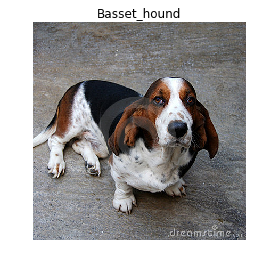

Image Shape: (380, 640, 3)


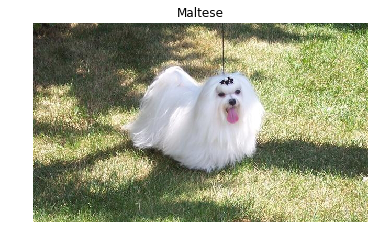

Image Shape: (640, 426, 3)


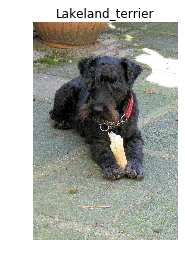

In [243]:
show_random_imgs(3)

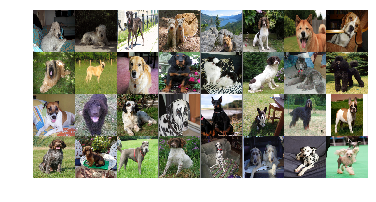

In [244]:
# Get a batch of training data (32 random images)
imgs, classes = next(iter(dataloaders['Train']))

# This PyTorch function makes a grid of images from a batch for us
batch = torchvision.utils.make_grid(imgs)

show_batch(batch)

#### Defining a network in PyTorch

Now its time to finally build our CNN.  In PyTorch, a model is represented by a normal Python class that inherits from the master nn.Module class. Inheriting from this master class grants your model all the methods and attributes needed to train and work with your model. There are, however, 2 things you need to write yourself:
 -  **__init__(self)**: Here is where you define the layers and overall architecture of your model
 -  **forward(self, x)**: This method takes an input, x, computes a forward pass through the network and outputs predictions. Writing it essentially involves connecting your layers and setting up the flow of the input through your layers.
 
 

Below are the signatures of the PyTorch functions that create each of the layers we discussed. Try to use them to build your first CNN! I provided some comments that hopefully guide you in terms of what should happen at each step.

-  nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
-  nn.ReLU(x)
-  nn.MaxPool2d(kernel_size, stride, padding)
-  nn.BatchNorm2d(num_features) - num_features is the number of channels it receives
-  nn.Dropout(p) - p is probability of an element to be zeroed
-  nn.Linear(in_features, out_features) – fully connected layer (matrix multiplications used in the classification portion of a network)

In [1]:
# It is good practice to maintain input dimensions as the image is passed through convolution layers
# With a default stride of 1, and no padding, a convolution will reduce image dimenions to:
            # out = in - m + 1, where m is the size of the kernel and in is a dimension of the input

# Use this function to calculate the padding size neccessary to create an output of desired dimensions

def get_padding(input_dim, output_dim, kernel_size, stride):
  # Calculates padding necessary to create a certain output size,
  # given a input size, kernel size and stride
  
  padding = (((output_dim - 1) * stride) - input_dim + kernel_size) // 2
  
  if padding < 0:
    return 0
  else:
    return padding

In [0]:
# Make sure you calculate the padding amount needed to maintain the spatial size of the input
# after each Conv layer

class CNN(nn.Module):
  
    def __init__(self):
        super(CNN, self).__init__()
        
        # nn.Sequential() is simply a container that groups layers into one object
        # Pass layers into it separated by commas
        self.block1 = nn.Sequential(
            
            # The first convolutional layer. Think about how many channels the input starts off with
            # Let's have this first layer extract 32 features
            ### BEGIN SOLUTION
            nn.Conv2d(3, 32, 3, 1, 1),
            ### END SOLUTION
            
            # Don't forget to apply a non-linearity
            ### BEGIN SOLUTION
            nn.ReLU())
            ### END SOLUTION
        
        self.block2 =  nn.Sequential(
            
            # The second convolutional layer. How many channels does it receive, given the number of features extracted by the first layer?
            # Have this layer extract 64 features
            ### BEGIN SOLUTION
            nn.Conv2d(32, 64, 3, 1, 1),
            ### END SOLUTION
            
            # Non linearity
            ### BEGIN SOLUTION
            nn.ReLU(),
            ### END SOLUTION
            
            # Lets introduce a Batch Normalization layer
            ### BEGIN SOLUTION
            nn.BatchNorm2d(64),
            ### END SOLUTION
            
            # Downsample the input with Max Pooling
            ### BEGIN SOLUTION
            nn.MaxPool2d(2, 2, 0)
            ### END SOLUTION
        )
        
        # Mimic the second block here, except have this block extract 128 features
        self.block3 =  nn.Sequential(
            ### BEGIN SOLUTION
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2, 0)
            ### END SOLUTION
        )
        
        # Applying a global pooling layer
        # Turns the 128 channel rank 4 tensor into a rank 2 tensor of size 32 x 128 (32 128-length arrays, one for each of the inputs in a batch)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layer
        self.fc1 = nn.Linear(128, 512)
        
        # Introduce dropout to reduce overfitting
        self.drop_out = nn.Dropout(0.5)
        
        # Final fully connected layer creates the prediction array
        self.fc2 = nn.Linear(512, len(dog_breeds))
    
    # Feed the input through each of the layers we defined 
    def forward(self, x):
        
        # Input size changes from (32 x 3 x 224 x 224) to (32 x 32 x 224 x 224)
        x = self.block1(x)
        
        # Size changes from (32 x 32 x 224 x 224) to (32 x 64 x 112 x 112) after max pooling
        x = self.block2(x)
        
        # Size changes from (32 x 64 x 112 x 112) to (32 x 128 x 56 x 56) after max pooling
        x = self.block3(x)
        
        # Reshapes the input from (32 x 128 x 56 x 56) to (32 x 128)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layer, size changes from (32 x 128) to (32 x 512)
        x = self.fc1(x)
        x = self.drop_out(x)
        
        # Size change from (32 x 512) to (32 x 133) to create prediction arrays for each of the images in the batch
        x = self.fc2(x)
        
        return x

Now we create an instance of this CNN() class and define the loss function and optimizer we'll use to train our model. In our case we'll use CrossEntropyLoss. You'll notice we never added a Softmax activation after our last layer. That's because PyTorch's CrossEntropyLoss applies a softmax before calculating log loss, a commonly used loss function for single label classification problems.

For the optimizer we'll use Adam, an easy to apply but powerful optimizer which is an extension of the popular Stochastic Gradient Descent method. We need to pass it all of the parameters it'll train, which PyTorch makes easy with model.parameters(), and also the learning rate we'll use.

In [247]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
epochs = 20
model.to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          18,496
              ReLU-4         [-1, 64, 224, 224]               0
       BatchNorm2d-5         [-1, 64, 224, 224]             128
         MaxPool2d-6         [-1, 64, 112, 112]               0
            Conv2d-7        [-1, 128, 112, 112]          73,856
              ReLU-8        [-1, 128, 112, 112]               0
       BatchNorm2d-9        [-1, 128, 112, 112]             256
        MaxPool2d-10          [-1, 128, 56, 56]               0
AdaptiveAvgPool2d-11            [-1, 128, 1, 1]               0
           Linear-12                  [-1, 512]          66,048
          Dropout-13                  [-1, 512]               0
           Linear-14                  [

## Training a model in PyTorch 

At this point we're finally ready to train our model! In PyTorch we have to write our own training loops before getting to actually train the model. This can seem daunting at first, so let's break up each stage of the training process. 

The bulk of the function is handled by a nested for loop, the outer looping through each epoch and the inner looping through all of the batches of images in our dataset. Each epoch has a training and validation phase, where batches are served from their respective loaders. Both phases begin by feeding a batch of inputs into the model, which implicity calls the forward() function on the input. Then we calculate the loss of the outputs against the true labels of the batch. 

If we're in training mode, here is where we perform back-propagation and adjust our weights. To do this, we first zero the gradients, then perform backpropagation by calling .backward() on the loss variable. Finally, we call optimizer.step() to adjust the weights of the model in accordance with the calculated gradients.

The remaining portion of one epoch is the same for both training and validation, and simply involves calculating and tracking the accuracy achieved in both phases. A nifty addition to this training loop is that it tracks the highest validation accuracy and only saves weights which beat that accuracy, ensuring that the best performing weights are returned from the function.

In [2]:
def run_epoch(epoch, model, dataloaders, device, phase):
  
    running_loss = 0.0
    running_corrects = 0

    if phase == 'Train':
        model.train()
    else:
        model.eval()

    # Looping through batches
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
    
        # ensures we're doing this calculation on our GPU if possible
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero parameter gradients
        optimizer.zero_grad()
    
        # Calculate gradients only if we're in the training phase
        with torch.set_grad_enabled(phase == 'Train'):
      
            # This calls the forward() function on a batch of inputs
            outputs = model(inputs)

            # Calculate the loss of the batch
            loss = criterion(outputs, labels)

            # Gets the predictions of the inputs (highest value in the array)
            _, preds = torch.max(outputs, 1)

            # Adjust weights through backpropagation if we're in training phase
            if phase == 'Train':
                loss.backward()
                optimizer.step()

        # Document statistics for the batch
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    # Calculate epoch statistics
    epoch_loss = running_loss / image_datasets[phase].__len__()
    epoch_acc = running_corrects.double() / image_datasets[phase].__len__()

    return epoch_loss, epoch_acc


In [0]:
def train(model, criterion, optimizer, num_epochs, dataloaders, device):
    start = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    print('| Epoch\t | Train Loss\t| Train Acc\t| Valid Loss\t| Valid Acc\t| Epoch Time |')
    print('-' * 86)
    
    # Iterate through epochs
    for epoch in range(num_epochs):
        
        epoch_start = time.time()
       
        # Training phase
        train_loss, train_acc = run_epoch(epoch, model, dataloaders, device, 'Train')
        
        # Validation phase
        val_loss, val_acc = run_epoch(epoch, model, dataloaders, device, 'Validation')
        
        epoch_time = time.time() - epoch_start
           
        # Print statistics after the validation phase
        print("| {}\t | {:.4f}\t| {:.4f}\t| {:.4f}\t| {:.4f}\t| {:.0f}m {:.0f}s     |"
                      .format(epoch + 1, train_loss, train_acc, val_loss, val_acc, epoch_time // 60, epoch_time % 60))

        # Copy and save the model's weights if it has the best accuracy thus far
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    total_time = time.time() - start
    
    print('-' * 74)
    print('Training complete in {:.0f}m {:.0f}s'.format(total_time // 60, total_time % 60))
    print('Best validation accuracy: {:.4f}'.format(best_acc))

    # load best model weights and return them
    model.load_state_dict(best_model_wts)
    return model

#### Testing a model

Creating a function that generates and prints predictions on a given number of images from our test set:

In [0]:
def test_model(model, num_images):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(num_images, (10,10))

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Actual: {} \n Prediction: {}'.format(dog_breeds[labels[j]], dog_breeds[preds[j]]))
                
                image = images.cpu().data[j].numpy().transpose((1, 2, 0))
                
                mean = np.array([0.5, 0.5, 0.5])
                std = np.array([0.5, 0.5, 0.5])
                image = std * image + mean
                image = np.clip(image, 0, 1)
                
                plt.imshow(image)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

After defining these functions, training and testing our model is straightforward from here on out. Simply call the train() function with the required parameters and let your GPU go to work!

In [251]:
model = train(model, criterion, optimizer, epochs, dataloaders, device)

| Epoch	 | Train Loss	| Train Acc	| Valid Loss	| Valid Acc	| Epoch Time |
--------------------------------------------------------------------------------------
| 1	 | 4.8730	| 0.0111	| 4.8074	| 0.0275	| 1m 41s     |
| 2	 | 4.7630	| 0.0269	| 4.7455	| 0.0263	| 1m 42s     |
| 3	 | 4.6986	| 0.0275	| 4.6984	| 0.0299	| 1m 41s     |
| 4	 | 4.6266	| 0.0377	| 4.6528	| 0.0323	| 1m 42s     |
| 5	 | 4.5907	| 0.0382	| 4.6263	| 0.0359	| 1m 41s     |
| 6	 | 4.5327	| 0.0425	| 4.5751	| 0.0371	| 1m 41s     |
| 7	 | 4.4862	| 0.0512	| 4.5453	| 0.0371	| 1m 41s     |
| 8	 | 4.4388	| 0.0572	| 4.5135	| 0.0419	| 1m 41s     |
| 9	 | 4.3907	| 0.0612	| 4.5000	| 0.0431	| 1m 42s     |
| 10	 | 4.3388	| 0.0614	| 4.4512	| 0.0479	| 1m 41s     |
| 11	 | 4.2908	| 0.0618	| 4.4134	| 0.0527	| 1m 42s     |
| 12	 | 4.2392	| 0.0735	| 4.3819	| 0.0563	| 1m 41s     |
| 13	 | 4.1882	| 0.0766	| 4.3597	| 0.0527	| 1m 43s     |
| 14	 | 4.1450	| 0.0828	| 4.3101	| 0.0659	| 1m 42s     |
| 15	 | 4.1152	| 0.0861	| 4.2791	| 0.0683	| 1m 43s

Ouch! Our model doesn't seem to be performing very well at all. After 20 epochs of training we're barely able to achieve a 10% accuracy on our validation set... Hang in there, in a bit I'll go into some methods we can use to achieve a much better accuracy.

In the meantime, let's quickly take a look at how we can save our PyTorch models. Then we'll test and visualize our model. 

## Saving a model in PyTorch 

There are many ways to save a PyTorch model, however the most robust method is described below. This allows you to load up a model for both testing and further training.

The most important part to understand from the code below is what the model and optimizer **state_dict's** are. The model state_dict is essentially a dictionary which contains all of the learned weights and biases in the model, while the optimizer contains information about the optimizer’s state hyperparameters used.

Other than the state_dicts, we also save the class used to build the model architecture, as well as the optimizer and loss function. Putting all of this together allows us to save, move around, and later restore our model to it's exact state after training.. A **.tar** file extension is commonly used to bundle all of this together.

In [0]:
torch.save({
            'model' : CNN(),
            'epoch' : epochs,
            'model_state_dict': model.state_dict(),
            'optimizer' : optimizer,
            'optimizer_state_dict': optimizer.state_dict(),
            'criterion' : criterion,
            'device' : device
            }, 'base_model.tar')

/anaconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Creating a function which unpacks the .tar file we saved earlier and loads up the model's saved weights and optimizer state:

In [0]:
def load_checkpoint(filepath):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(filepath, map_location=device)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = checkpoint['optimizer']
    optimizer = optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    criterion = checkpoint['criterion']
    epoch = checkpoint['epoch']
    model.to(device)

    return model, optimizer, criterion, epoch

Loading our model up...

In [0]:
model, optimizer, criterion, epoch = load_checkpoint(root + 'base_model.tar')

Let's test our model on a couple of dogs!

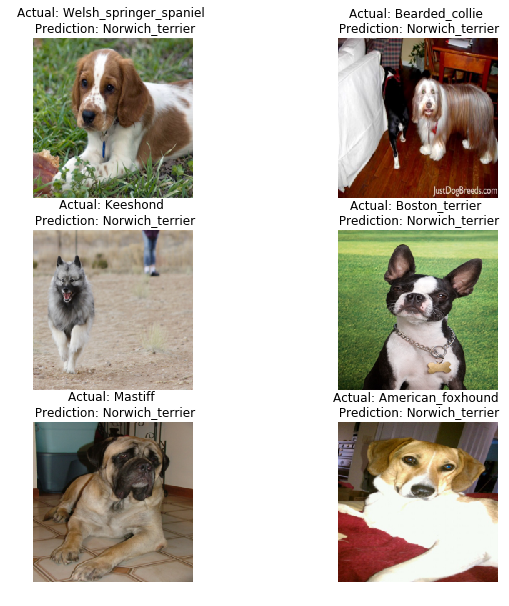

In [0]:
test_model(model, 6)

As expected, our model is predicting the wrong breed for the majority of test images. Why is this?

In short, building and training a CNN from scratch is possible, however most problems require significantly more complex models, trained on huge amounts of data. Of course, the computational power and amount of data needed to train these networks accurately are not always available. This is why the idea of **Transfer Learning** has become so popular. It allows everyday people, like me and you, to build accurate and powerful models with limited resources.

## Transfer Learning  

In transfer learning, we take the architecture and weights of a pre-trained model 
(one that has been trained on millions of images belonging to 1000’s of classes, on several high power GPU’s for several days) 
and use the pre-learned features to solve our own novel problem.

PyTorch actually comes with a number of models which have already been trained on the Imagenet dataset we discussed earlier, making it quite simple for us to apply this method of transfer learning. We'll be using a powerful but lighweight model called ResNet18, which we import like so:
-  from torchvision.models import resnet18

The next block of code might look a bit foreign. What we're doing is actually looping through all of the model's pretrained weights and **freezing** them. This means that during training, these weights will not be updating at all. We then take the entire ResNet model and put it into one block of our model, named feature_extraction. It's important to understand that when you load a pretrained model you are only receiving the feature extraction block, or the convolutional layers. It's up to us to define a classification block which can take all of the features the ResNet model extracted and use them to actually classify an image.

In [0]:
class PreTrained_Resnet(nn.Module):
    def __init__(self):
        super(PreTrained_Resnet, self).__init__()
        
        # Loading up a pretrained ResNet18 model
        resnet = resnet18(pretrained = True)
        
        # Freeze the entire pretrained network
        for layer in resnet.parameters():
            layer.requires_grad = False
            
        self.feature_extraction = resnet
        
        # Write the classifier block for this network      
            # Tip: ResNet18's feature extraction portion ends up with 1000 feature maps, and then implements a Global Average Pooling layer
            # So what would the size and dimension of the output tensor be?
            # Think about how can we take that output tensor and transform it into an array of dog breed predictions...
        self.classifier = nn.Sequential(
            ### BEGIN SOLUTION
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, len(dog_breeds))
            ### END SOLUTION
        )
    
    # Write the forward method for this network (it's quite simple since we've defined the network in blocks already)
    def forward(self, x):
        ### BEGIN SOLUTION
        x = self.feature_extraction(x)
        x = self.classifier(x)
        return x
        ### END SOLUTION

In [0]:
# Instantiate a pretrained network using the class we've just defined (call it 'pretrained')

### BEGIN SOLUTION
pretrained = PreTrained_Resnet()
### END SOLUTION

# Then define the loss function and optimizer to use for training (let's use Adam again, with the same parameters as before)
### BEGIN SOLUTION
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(pretrained.classifier.parameters(), lr = 0.0001)
### END SOLUTION

# Define your number of epochs to train and map your model to the gpu
### BEGIN SOLUTION
epochs2 = 10
pretrained.to(device)
### END SOLUTION

summary(pretrained, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [0]:
pretrained = train(pretrained, criterion2, optimizer2, epochs2, dataloaders, device)

| Epoch	 | Train Loss	| Train Acc	| Valid Loss	| Valid Acc	| Epoch Time |
--------------------------------------------------------------------------------------
| 1	 | 1.6224	| 0.5662	| 1.0972	| 0.7114	| 2m 36s     |
| 2	 | 1.2853	| 0.6341	| 0.9292	| 0.7353	| 2m 36s     |
| 3	 | 1.0934	| 0.6793	| 0.8318	| 0.7593	| 2m 36s     |
| 4	 | 0.9803	| 0.7085	| 0.7717	| 0.7808	| 2m 36s     |
| 5	 | 0.9004	| 0.7314	| 0.7314	| 0.7820	| 2m 37s     |
| 6	 | 0.8064	| 0.7612	| 0.6959	| 0.8060	| 2m 37s     |
| 7	 | 0.7250	| 0.7844	| 0.6893	| 0.8084	| 2m 36s     |
| 8	 | 0.6708	| 0.7918	| 0.6735	| 0.7940	| 2m 36s     |
| 9	 | 0.6583	| 0.7945	| 0.6502	| 0.8072	| 2m 36s     |
| 10	 | 0.6105	| 0.8139	| 0.6510	| 0.8024	| 2m 36s     |
| 11	 | 0.5881	| 0.8196	| 0.6402	| 0.8132	| 2m 37s     |
| 12	 | 0.5464	| 0.8305	| 0.6355	| 0.7964	| 2m 36s     |
| 13	 | 0.5263	| 0.8394	| 0.6205	| 0.8084	| 2m 36s     |
| 14	 | 0.5085	| 0.8436	| 0.6160	| 0.8048	| 2m 37s     |
| 15	 | 0.4770	| 0.8487	| 0.6205	| 0.8108	| 2m 36s

This quick example shows the power of transfer learning. With relatively few lines of code we're able to achieve over an 80% accuracy on this dog breeds dataset! And there are still a number of things we could have done, or do from here, to achieve even better performance. This includes things such as:
 -  Unfreezing the last few layers of the ResNet base and training some more on our specific dataset (more on this in a bit)
 -  Optimizing the hyperparameters of our model (learning rate, etc.)
 -  Utilizing an even more powerful pretrained architecture (Resnet34, 50, etc.)
 -  Creating a custom learning rate schedule

We'll save the model, then load it back up using the function we defined earlier.

In [0]:
torch.save({
            'model' : PreTrained_Resnet(),
            'epoch' : epochs2,
            'model_state_dict': pretrained.state_dict(),
            'optimizer' : optimizer2,
            'optimizer_state_dict': optimizer2.state_dict(),
            'criterion' : criterion2,
            'device' : device
            }, 'pretrained.tar')

/anaconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PreTrained_Resnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
pretrained, optimizer2, criterion2, epoch2 = load_checkpoint(root + 'pretrained.tar')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torchvision.models.resnet.BasicBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Finally we can test our new pretrained ResNet model! As you can see, with transfer learning we can create quite accurate models relatively easily.

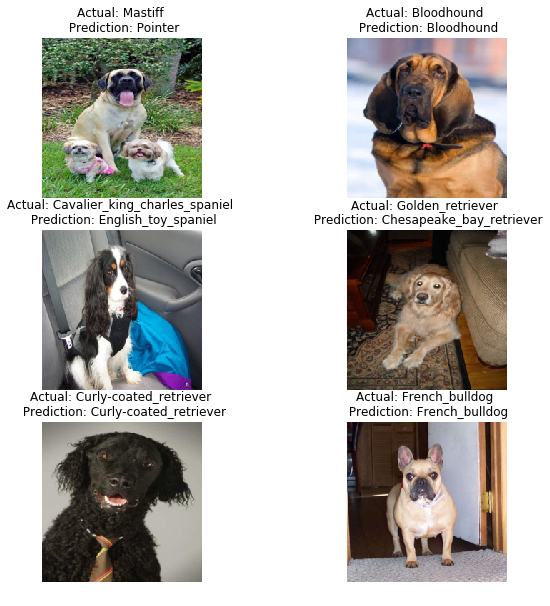

In [0]:
test_model(pretrained, 6)

#### More on Transfer Learning

In this example, we simply took a pretrained model and added our classification (fully connected layers) block right on top. We froze the entire pretrained network and only updated the weights of our fully connected layers. This means we didn't change the pretrained weights at all, and only used what it had 'learned' from the dataset which it was trained on. 

However, I mentioned earlier that we could achieve even better performance if we unfroze the last few layers of the pretrained model and trained them some on our specific dataset. But why?

<img src = "https://drive.google.com/uc?id=10ce5aTD47lIsO1eYfZmbs_sbDDUfaZiT"> <img src = "https://drive.google.com/uc?id=1BfHJXrWwl4oVyPZ2_p602nD9HkF4RoSR">

Going back to the layer visualizations we saw earlier, we know the earlier layers of the pretrained network learn to recognize simple lines, patterns, objects, etc. However, as we progress in the network, the layers learn to recognize things more specific to the dataset which it was trained on. In this case, ImageNet, which we described a bit earlier.

If you remember, ImageNet contains images that are *somewhat* similar to our dog breeds dataset, so much of what the model 'learned' also applied to our dataset. Hence why we were able to achieve a pretty good accuracy without adjusting the pretrained model whatsoever. 

Of course, much of what the deeper layers learned from ImageNet did **not** apply to dog images. This is why training the last few layers would be beneficial. It would allow the model to adjust and recognize rich features specific to **only dogs**. Things such as types of dog ears, tails, fur, noses, etc. etc.

## Thank you for coming out tonight! 

## Don't forget to sign in at <a href="ucfai.org/signin">ucfai.org/signin</a> if you didn't get the chance to swipe in, and see you next week!